In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest #para la prueba de hip de igualdad d proporcion
from scipy.stats import chi2_contingency


In [ ]:
#--------------CARGO DATA SET ATI ANON------------------------
archivo = "C:\\Users\\cordo\\UNIVERSIDAD\\3. Metodos para el analisis de datos\\Teoría\\ati_anonimo.xlsx"
df_info_extra = pd.read_excel(archivo)

# Mostrar las primeras filas del DataFrame
print(df_info_extra.head())

# Información general del dataset
print("\nInformación del dataset:")
print(df_info_extra.info())


In [ ]:
#-----------UNO LOS EXCELS Y CAMBIO NUMERO DE ID POR DNI--------------------------
df_anon=pd.read_excel(f'ati_anonimo.xlsx')
print(len(df_anon))
df_anon_unicos=df_anon.drop_duplicates(subset=['DNI','COMISION'],keep=False)
print(len(df_anon_unicos))


df_nuevo=pd.DataFrame(columns=['DNI','COMISION','ACTIVIDAD 1','ACTIVIDAD 2','ACTIVIDAD 3','ACTIVIDAD 4'])
df_nuevo[['DNI','COMISION']]=df_anon_unicos[['DNI','COMISION']]
df_nuevo['DNI']=df_nuevo['DNI'].astype(int)
df_nuevo['COMISION']=df_nuevo['COMISION'].astype(str)
for seguimiento in range(1,5):
    archivos_en_carpeta=os.listdir(f"Actividades de Seguimiento/Actividad de Seguimiento {seguimiento}")
   
    for archivo in archivos_en_carpeta:
        if archivo.endswith('.xlsx'):
            df_i_todo=pd.read_excel(f"Actividades de Seguimiento/Actividad de Seguimiento {seguimiento}/{archivo}")
            if 'Calificación/10,00' in df_i_todo.columns:   
                df_i = df_i_todo[['Número de ID','Calificación/10,00']]
            else:
                print(f"archivo {archivo} no tiene la columna 'Calificación/10,00'")
            match=re.search(r'\(([^)]+)\)',archivo)
            if match:
                comision=match.group(1)
                for index, row in df_i.iterrows():
                    dni=row['Número de ID']
                    calificacion=row['Calificación/10,00']
                    valor=str(dni)
                    match2=re.search(r'[a-zA-Z]', valor)
                    if not match2:
                        df_nuevo.loc[(df_nuevo['COMISION']==str(comision)) & (df_nuevo['DNI']==int(dni)), f'ACTIVIDAD {seguimiento}'] = float(str(calificacion).replace(',','.'))

        
            else:
                print(f"No se encontró la comisión en el archivo: {archivo}")

#-------------------agrego columna para analizar dsp con porcentaje, llamado nota_Seg
cols_actividades = ['ACTIVIDAD 1', 'ACTIVIDAD 2', 'ACTIVIDAD 3', 'ACTIVIDAD 4']

for col in cols_actividades:
    df_nuevo[col] = pd.to_numeric(df_nuevo[col], errors='coerce')

df_nuevo['NOTA_ACT_SEG'] = df_nuevo[cols_actividades].sum(axis=1, min_count=1)
df_nuevo.head()


In [4]:
#-------------------Vamos a unir los 2 data frame por DNI y por COMISION:-----------------------------------------

# Asegurarse de que los tipos de datos de las columnas comunes sean consistentes
df_info_extra['DNI'] = df_info_extra['DNI'].astype(str).str.strip()
df_nuevo['DNI'] = df_nuevo['DNI'].astype(str).str.strip()
df_info_extra['COMISION'] = df_info_extra['COMISION'].astype(str).str.strip()
df_nuevo['COMISION'] = df_nuevo['COMISION'].astype(str).str.strip()

df_pruebas = df_info_extra.drop_duplicates(subset=['DNI','COMISION','NOTA',], keep=False)

# Hacer el merge usando 'DNI' y 'COMISION' como claves
#df_anon_mas_segui = pd.merge(df_info_extra, df_nuevo, on=['DNI', 'COMISION'], how='left')
df_anon_mas_segui = pd.merge(df_pruebas, df_nuevo, on=['DNI', 'COMISION'], how='outer')

# Exportar el resultado a un archivo Excel
#df_anon_mas_segui.to_excel('anon_mas_segui.xlsx', index=False)

# Verificar el resultado
print("Columnas en df_anon_mas_segui:", df_anon_mas_segui.columns)
df_anon_mas_segui.head()
print(len(df_anon_mas_segui))


Columnas en df_anon_mas_segui: Index(['COMISION', 'ACTA', 'NRO. INSCR', 'CARRERA', 'Carrera-Nom', 'Columna1',
       'Columna2', 'DNI', 'NOTA', 'ACTIVIDAD 1', 'ACTIVIDAD 2', 'ACTIVIDAD 3',
       'ACTIVIDAD 4', 'NOTA_ACT_SEG'],
      dtype='object')
3981


In [ ]:
#--------------------------TRABAJO CON DUPLICADOS-------------------------------------------------
print('Vemos DNI y COMISION de los duplicados no más:')
print(df_anon_mas_segui[df_anon_mas_segui['DNI'].duplicated(keep=False)][['DNI', 'COMISION']])


#vamos a crear un df con los duplicados para observarlos un poco:
duplicados = df_anon_mas_segui[df_anon_mas_segui['DNI'].duplicated(keep=False)].copy()
print('\n La cantidad de duplicados es: ',len(duplicados))


#------Me quedo con los que tienen las actividades de seg hechas:
filas_filtradas = []
dnis_unicos = duplicados['DNI'].unique()

for dni in dnis_unicos:
    filas_dni = duplicados[duplicados['DNI'] == dni]
    max_nota = filas_dni['NOTA_ACT_SEG'].max()
    
    # Si max_nota es NaN (todos NaN), me quedo con la primer fila del grupo. es lo mismo si es M o B
    if pd.isna(max_nota):
        fila_elegida = filas_dni.iloc[0]
    else:
        filas_max = filas_dni[filas_dni['NOTA_ACT_SEG'] == max_nota]
        fila_elegida = filas_max.iloc[0]
        
    filas_filtradas.append(fila_elegida)

duplicados_filtrados = pd.DataFrame(filas_filtradas)
print(duplicados_filtrados)

#pd.set_option('display.max_rows', None)
duplicados_filtrados




In [6]:
#----------------------------FILTRO LOS DUPLIS EN EL ORIGINAL
#1Identificar las filas no duplicadas en df_anon_mas_segui
no_duplicados = df_anon_mas_segui[~df_anon_mas_segui['DNI'].duplicated(keep=False)]

#2Combinar las filas no duplicadas con duplicados_filtrados
df_final = pd.concat([no_duplicados, duplicados_filtrados]).reset_index(drop=True)

#Exportar el resultado a Excel
df_final.to_excel('ati_anon_segui_filtrado.xlsx', index=False)

#vamos a crear un df con los duplicados para observarlos un poco:
duplicados2 = df_final[df_final['DNI'].duplicated(keep=False)].copy()
print('\n La cantidad de duplicados es: ',len(duplicados2)) #no los hay!!!!!!! :D

df_final.head()
print(len(df_final))


 La cantidad de duplicados es:  0
3812


In [ ]:
#-----------------------Completo mi DF CON HORARIOS----------------------------------------------
df_final['HORARIO_COMISION'] = ''

# Mostrar las primeras filas del DataFrame
#print('DF con columna hecha pero vacía')
#print(df_final.head()) #Chequeo que agregué efectivamente la columna.

#Veamos primero todas las comisiones que tenemos:
print(df_final['COMISION'].unique())


#Agrupamos las comisiones segun el horario que tiene cada uno.
grupo1 = ['M1','M9','B9','B7','B1','M23','B3','M21']
grupo2 = ['M3','M11','M27','M24','M17']
grupo3 = ['M2','M10','B6','B8','M16','B5','B2','M22']
grupo4 = ['M4','M12','M8','M26','B4']

#Segun el grupo que estan, asignamos horario en la columna creada anteriormente
#Para ellos usamos .loc permite seleccionar filas y columnas según una condición lógica o una etiqueta específica
df_final.loc[df_final['COMISION'].isin(grupo1), 'HORARIO_COMISION'] = '08-10'
df_final.loc[df_final['COMISION'].isin(grupo2), 'HORARIO_COMISION'] = '1030-1230'
df_final.loc[df_final['COMISION'].isin(grupo3), 'HORARIO_COMISION'] = '16-18'
df_final.loc[df_final['COMISION'].isin(grupo4), 'HORARIO_COMISION'] = '1830-2030'

print('\n DF completo:')
df_final.head()



In [8]:
df_final.head()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3812 entries, 0 to 3811
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   COMISION          3812 non-null   object 
 1   ACTA              3812 non-null   int64  
 2   NRO. INSCR        3812 non-null   int64  
 3   CARRERA           3812 non-null   object 
 4   Carrera-Nom       3812 non-null   object 
 5   Columna1          0 non-null      float64
 6   Columna2          0 non-null      float64
 7   DNI               3812 non-null   object 
 8   NOTA              3812 non-null   object 
 9   ACTIVIDAD 1       2518 non-null   float64
 10  ACTIVIDAD 2       2465 non-null   float64
 11  ACTIVIDAD 3       2272 non-null   float64
 12  ACTIVIDAD 4       1337 non-null   float64
 13  NOTA_ACT_SEG      2670 non-null   float64
 14  HORARIO_COMISION  3812 non-null   object 
dtypes: float64(7), int64(2), object(6)
memory usage: 446.8+ KB


In [9]:
#---------------------- UN POCO DE INFO (números) DEL DF-----------------------
print(df_final.columns)

df_final['TIPO_COMISION'] = df_final['COMISION'].str[0]  # Toma la primera letra y armo una columna para ver si estan en comision M o B
df_final['TIPO_COMISION'].value_counts()

# Total de estudiantes 
total_estudiantes = len(df_final)
print(f"Número total de estudiantes: {total_estudiantes}")

duplicados_completos = df_final.duplicated().sum()
print(f"Número de filas completamente duplicadas: {duplicados_completos}")

df_ausentes = df_final[df_final['NOTA'] == 'Ausente']
print(f'la cantidad de estudiantes ausentes fue: {len(df_ausentes)}')

df_presentes = df_final[df_final['NOTA'] != 'Ausente']
print(f'la cantidad de estudiantes que se presentaron a rendir fue: {len(df_presentes)}')

df_comision_b = df_final[df_final['TIPO_COMISION'] == 'B']
print(f'la cantidad de estudiantes anotados en la comision B fueron: {len(df_comision_b)}')


df_comision_m = df_final[df_final['TIPO_COMISION'] == 'M']
print(f'la cantidad de estudiantes anotados en la comision M fueron: {len(df_comision_m)}')

# Calcular totales por categoría (aprobados y desaprobados) y totales por tipo de curso
resumen = df_presentes.groupby(['TIPO_COMISION', 'NOTA']).size().unstack(fill_value=0)
resumen['Total'] = resumen['Aprobado'] + resumen['Desaprobado']
resumen['Tasa de Aprobación (%)'] = (resumen['Aprobado'] / resumen['Total'] * 100).round(1)

# Mostrar la tabla de resultados
print(resumen)

Index(['COMISION', 'ACTA', 'NRO. INSCR', 'CARRERA', 'Carrera-Nom', 'Columna1',
       'Columna2', 'DNI', 'NOTA', 'ACTIVIDAD 1', 'ACTIVIDAD 2', 'ACTIVIDAD 3',
       'ACTIVIDAD 4', 'NOTA_ACT_SEG', 'HORARIO_COMISION'],
      dtype='object')
Número total de estudiantes: 3812
Número de filas completamente duplicadas: 0
la cantidad de estudiantes ausentes fue: 1226
la cantidad de estudiantes que se presentaron a rendir fue: 2586
la cantidad de estudiantes anotados en la comision B fueron: 1440
la cantidad de estudiantes anotados en la comision M fueron: 2372
NOTA           Aprobado  Desaprobado  Total  Tasa de Aprobación (%)
TIPO_COMISION                                                      
B                   588          343    931                    63.2
M                   936          719   1655                    56.6


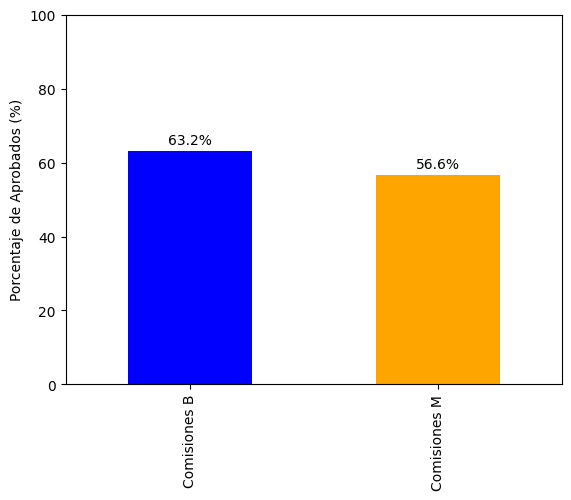

In [10]:
#--------------- 1. Estadísticas descriptivas: Calcular tasas de aprobación para cursos B vs M
#----------------------Histograma aprobacion. Comisiones B y M------------------
df_final.columns
df_final['COMISION'].unique()

df_final['TIPO_COMISION'] = df_final['COMISION'].str[0]  # Toma la primera letra y armo una columna para ver si estan en comision M o B
df_final['TIPO_COMISION'].value_counts()


df_presentes = df_final[df_final['NOTA'] != 'Ausente'] #Vamos a eliminar a los ausentes del df para un mejor analisis
df_presentes = df_presentes.copy()
df_presentes['TIPO_COMISION'] = df_final.loc[df_presentes.index, 'TIPO_COMISION']
df_presentes['NOTA'].value_counts() #aca vemos cuandos aprobados y desaprobados hay!


contadorM_ap = 0
contadorM_des = 0
contadorB_ap = 0
contadorB_des = 0

for i, fila in df_presentes.iterrows():
    nota = fila['NOTA']
    tipo = fila['TIPO_COMISION']

    if tipo == 'M':
        if nota == 'Aprobado':
            contadorM_ap += 1
        elif nota == 'Desaprobado':
            contadorM_des += 1
    elif tipo == 'B':
        if nota == 'Aprobado':
            contadorB_ap += 1
        elif nota == 'Desaprobado':
            contadorB_des += 1

porcentaje_M = 100 * contadorM_ap / (contadorM_ap + contadorM_des)
porcentaje_B = 100 * contadorB_ap / (contadorB_ap + contadorB_des)

'''  

# Calcular totales por categoría (aprobados y desaprobados) y totales por tipo de curso
resumen = df_presentes.groupby(['TIPO_COMISION', 'NOTA']).size().unstack(fill_value=0)
resumen['Total'] = resumen['Aprobado'] + resumen['Desaprobado']
resumen['Tasa de Aprobación (%)'] = (resumen['Aprobado'] / resumen['Total'] * 100).round(1)

# Mostrar la tabla de resultados
print(resumen)

 '''

# Crear serie con los porcentajes
serie = pd.Series({'Comisiones B': porcentaje_B, 'Comisiones M': porcentaje_M})

# Graficar
ax = serie.plot(kind='bar', color=['blue', 'orange'], ylabel='Porcentaje de Aprobados (%)', ylim=(0, 100))
#ax = serie.plot(kind='bar', color=['blue', 'red'], ylabel='Porcentaje de Aprobados (%)', title='Aprobación por tipo de comisión (M o B)', ylim=(0, 100)) 

# Agregar etiquetas de porcentaje sobre las barras
for i, valor in enumerate(serie):
    ax.text(i, valor + 1, f'{valor:.1f}%', ha='center', va='bottom', fontsize=10)



In [11]:
#--------------- 2. Test de homogeneidad: Verificar si las poblaciones son comparables-----------------

#pd.crosstab(df_presentes['TIPO_COMISION'], df_presentes['CARRERA'])
#pd.crosstab(df_presentes['TIPO_COMISION'], df_presentes['HORARIO_COMISION'])

# Tabla de contingencia para TIPO_COMISION y CARRERA
contingencia_carrera = pd.crosstab(df_presentes['TIPO_COMISION'], df_presentes['CARRERA'])
print("Tabla de contingencia (TIPO_COMISION vs CARRERA):")
print(contingencia_carrera)

# Test de chi-cuadrado para homogeneidad
stat, p_value, dof, expected = chi2_contingency(contingencia_carrera)
print(f'Estadístico chi-cuadrado: {stat:.3f}')
print(f'Valor p: {p_value:.3f}')


#por horario--------------------------

# Tabla de contingencia para TIPO_COMISION y HORARIO_COMISION
contingencia_horario = pd.crosstab(df_presentes['TIPO_COMISION'], df_presentes['HORARIO_COMISION'])
print("Tabla de contingencia (TIPO_COMISION vs HORARIO_COMISION):")
print(contingencia_horario)

# Test de chi-cuadrado para homogeneidad
stat, p_value, dof, expected = chi2_contingency(contingencia_horario)
print(f'Estadístico chi-cuadrado: {stat:.3f}')
print(f'Valor p: {p_value:.3f}')

Tabla de contingencia (TIPO_COMISION vs CARRERA):
CARRERA          2    3   4    6   7   9   10  14  15  20  ...  188  197  200  \
TIPO_COMISION                                              ...                  
B              244    0   0    0   0   0  117   0   0  62  ...    1    0    0   
M                0  173  56  130  86  35    0   3  23   0  ...    0  317   17   

CARRERA        202  206  211  216  218  219  TAU  
TIPO_COMISION                                     
B                0    0    0    0   77    0    0  
M              160   35    9   10    0    5    4  

[2 rows x 41 columns]
Estadístico chi-cuadrado: 2586.000
Valor p: 0.000
Tabla de contingencia (TIPO_COMISION vs HORARIO_COMISION):
HORARIO_COMISION  08-10  1030-1230  16-18  1830-2030
TIPO_COMISION                                       
B                   408          0    410        113
M                   410        544    362        339
Estadístico chi-cuadrado: 496.184
Valor p: 0.000


In [12]:
#--------------- 3.  Análisis de diferencias: Aplicar test de proporciones (z-test o chi-cuadrado)----------------

''' 
H0: pB = pM
H1: pB != pM

pB: proporcion de aprobados en B
pM: proporcion de aprobados en M
'''


x=[contadorB_ap,contadorM_ap] #número de aprobados en B y M
n=[contadorB_ap+contadorB_des,contadorM_ap+contadorM_des]  ## número total de estudiantes en B y M

# Prueba de hipótesis (por defecto, bilateral)
stat, p_value = proportions_ztest(count=x, nobs=n)

print(f'Estadístico Z: {stat:.3f}')
print(f'Valor p: {p_value:.3f}')



Estadístico Z: 3.276
Valor p: 0.001


In [13]:
from scipy.stats import chi2_contingency
import numpy as np

# Creamos la tabla de contingencia
tabla = np.array([
    [607, 354],  # B: Aprobados, No aprobados
    [969, 737]   # M: Aprobados, No aprobados
])

# Aplicamos el test chi-cuadrado
chi2, p, dof, esperados = chi2_contingency(tabla)

print(f"Chi2 = {chi2:.2f}")
print(f"p-value = {p:.4f}")


Chi2 = 10.04
p-value = 0.0015


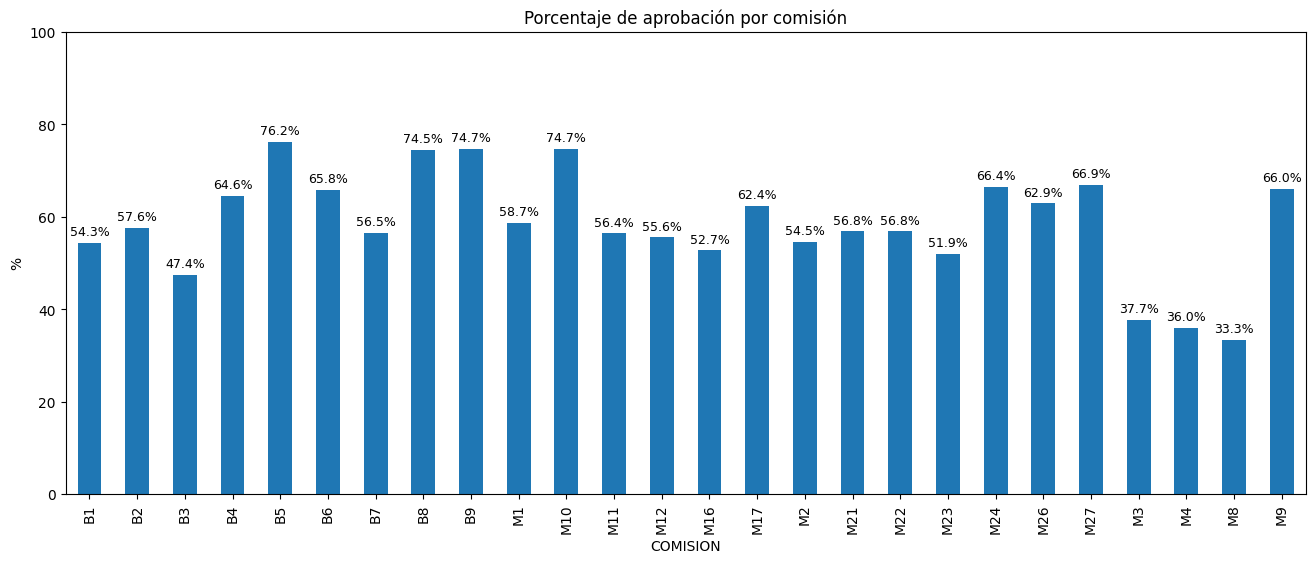

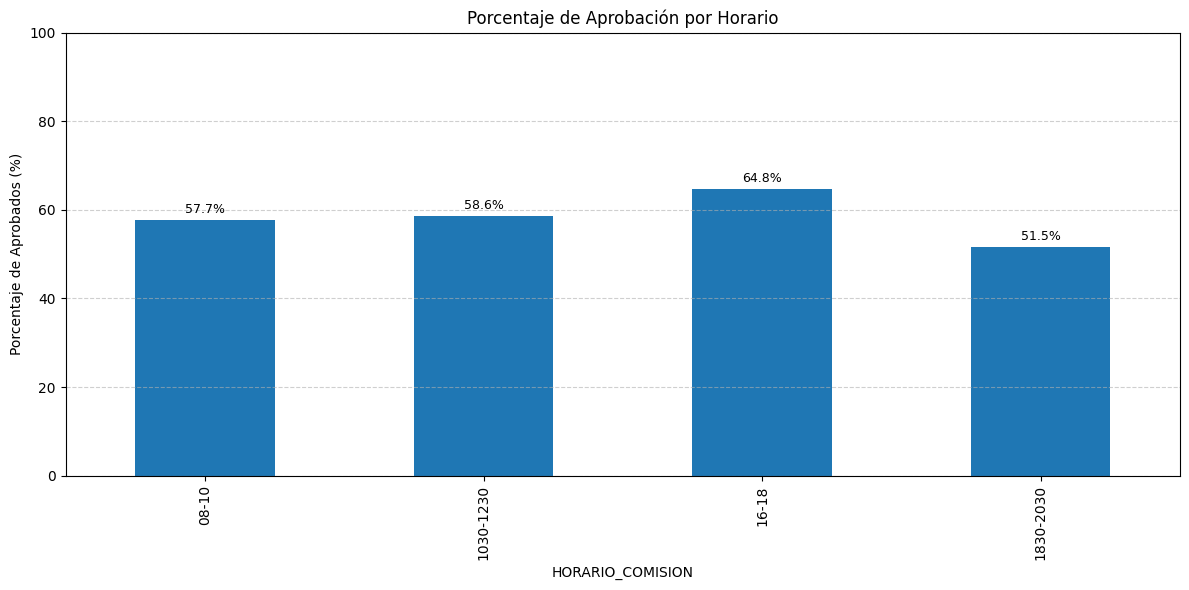

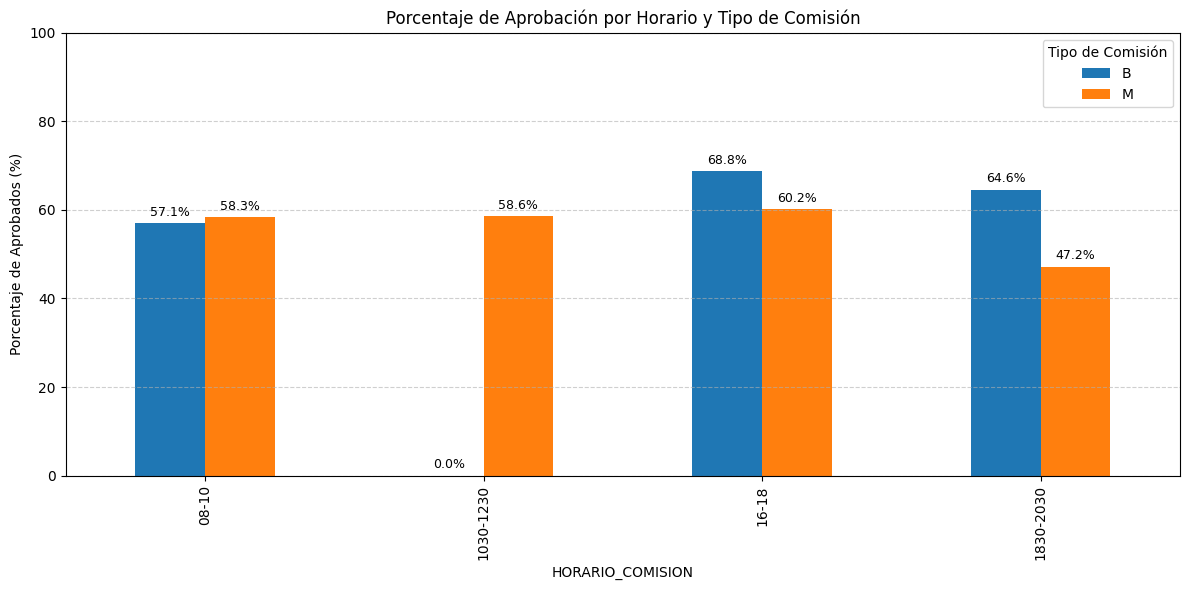

In [14]:
#--------------- 4. Análisis estratificado: Comparar B vs M dentro de cada carrera/comisión/horario 


#-----------------------Histograma de aprobación por comisión-----------------------------------------------------
porcentaje_por_comision = (
    df_presentes
    .groupby('COMISION')['NOTA']  #Agrupa el DataFrame por la columna COMISION. Para cada grupo (por ejemplo, B1, B5, M1, M3...), toma la columna NOTA.
    .value_counts(normalize=True)  #Para cada grupo, cuenta cuántas veces aparece cada valor único en NOTA. normalize=True hace que, en vez de contar cantidades, calcule la proporción o porcentaje (entre 0 y 1) de cada valor dentro del grupo.
    .unstack(fill_value=0)         #value_counts genera un Series con un índice múltiple (COMISION, NOTA).unstack() convierte el segundo nivel del índice (NOTA) en columnas. 
                                   #Así, se transforma en un DataFrame con una fila por comisión y columnas para cada valor de NOTA. fill_value=0 rellena con 0 donde no hay datos (por ejemplo, si no hubo desaprobados en una comisión).
    .assign(porcentaje_aprobado=lambda x: x['Aprobado'] * 100)
)

ax1=porcentaje_por_comision['porcentaje_aprobado'].sort_index().plot(kind='bar', figsize=(16, 6), ylabel='%', title='Porcentaje de aprobación por comisión', ylim=(0, 100))

for i, valor in enumerate(porcentaje_por_comision['porcentaje_aprobado'].sort_index()):
    ax1.text(i, valor + 1, f'{valor:.1f}%', ha='center', va='bottom', fontsize=9) #con esto agregamos una etiqueta que diga el porcentaje por cada comision


'''
#------------------------Distribucion de carreras x comision---------------------------------------------------------------------
tabla_carrera = pd.crosstab(df_presentes['CARRERA'], df_presentes['TIPO_COMISION'], normalize='index') * 100
#print(tabla_carrera.round(1))

tabla_carrera.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.ylabel('Distribución (%)')
plt.title('Distribución de carreras por tipo de comisión (B vs M)')
plt.legend(title='Tipo de Comisión')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
'''
#------------------------Porcentaje de Aprobación por Horario -----------------------------------------------------------------------------
#------------------------Porcentaje de Aprobación por Horario ------------------------------

# Filtrar solo Aprobado/Desaprobado
df_analisis = df_presentes[df_presentes['NOTA'].isin(['Aprobado', 'Desaprobado'])]

# Calcular proporciones de aprobación
tabla = (
    df_analisis
    .groupby(['HORARIO_COMISION'])['NOTA']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
)

# Agregar columna con el porcentaje de aprobados
tabla['porcentaje_aprobado'] = tabla['Aprobado'] * 100

# Armar el DataFrame solo con horario y porcentaje
grafico_df = tabla[['HORARIO_COMISION', 'porcentaje_aprobado']].set_index('HORARIO_COMISION').sort_index()

# Graficar
ax = grafico_df.plot(kind='bar', figsize=(12, 6), legend=False)
ax.set_ylabel('Porcentaje de Aprobados (%)')
ax.set_title('Porcentaje de Aprobación por Horario')
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.show()



#------------------------Porcentaje de Aprobación por Horario y Tipo de Comisión-----------------------------------------------------------------------------
# Filtrar solo Aprobado/Desaprobado
df_analisis = df_presentes[df_presentes['NOTA'].isin(['Aprobado', 'Desaprobado'])]

# Calcular proporciones de aprobación
tabla = (
    df_analisis
    .groupby(['HORARIO_COMISION', 'TIPO_COMISION'])['NOTA']
    .value_counts(normalize=True)
    .unstack(fill_value=0)  # columnas: Aprobado, Desaprobado
    .reset_index()
)

# Agregamos la columna con el % de aprobados
tabla['porcentaje_aprobado'] = tabla['Aprobado'] * 100

# Reorganizar para graficar: una fila por horario, columnas M y B
grafico_df = tabla.pivot(index='HORARIO_COMISION', columns='TIPO_COMISION', values='porcentaje_aprobado').fillna(0)

# Ordenar por horario si querés
grafico_df = grafico_df.sort_index()

ax = grafico_df.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel('Porcentaje de Aprobados (%)')
ax.set_title('Porcentaje de Aprobación por Horario y Tipo de Comisión')
ax.set_ylim(0, 100)
ax.legend(title='Tipo de Comisión')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.show()




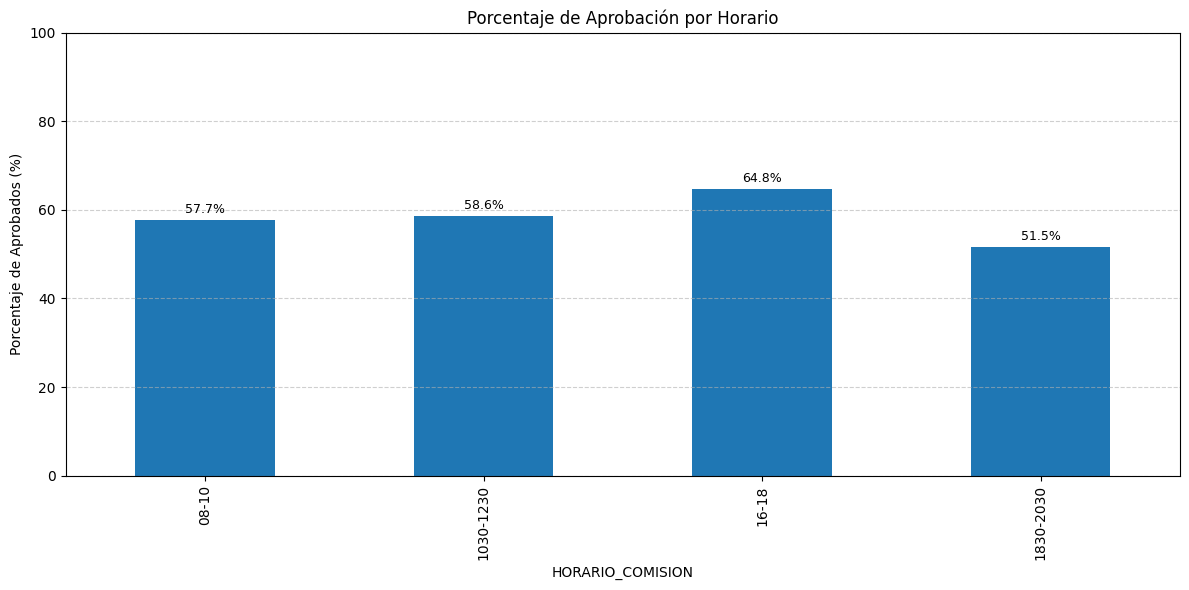

NOTA              Aprobado  Desaprobado
HORARIO_COMISION                       
08-10                  472          346
1030-1230              319          225
16-18                  500          272
1830-2030              233          219
Chi-cuadrado: 21.572
Grados de libertad: 3
p-valor: 0.00008


In [15]:
#------------------------Porcentaje de Aprobación por Horario ------------------------------

# Filtrar solo Aprobado/Desaprobado
df_analisis = df_presentes[df_presentes['NOTA'].isin(['Aprobado', 'Desaprobado'])]

# Calcular proporciones de aprobación
tabla = (
    df_analisis
    .groupby(['HORARIO_COMISION'])['NOTA']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
)

# Agregar columna con el porcentaje de aprobados
tabla['porcentaje_aprobado'] = tabla['Aprobado'] * 100

# Armar el DataFrame solo con horario y porcentaje
grafico_df = tabla[['HORARIO_COMISION', 'porcentaje_aprobado']].set_index('HORARIO_COMISION').sort_index()

# Graficar
ax = grafico_df.plot(kind='bar', figsize=(12, 6), legend=False)
ax.set_ylabel('Porcentaje de Aprobados (%)')
ax.set_title('Porcentaje de Aprobación por Horario')
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.show()


#----------------PRUEBA CHI-----------------------------------------------

# Filtrar solo aprobados y desaprobados (ya lo hiciste, pero para que esté claro)
df_analisis = df_presentes[df_presentes['NOTA'].isin(['Aprobado', 'Desaprobado'])]

# Crear tabla de contingencia: filas = HORARIO_COMISION, columnas = NOTA
tabla_contingencia = pd.crosstab(df_analisis['HORARIO_COMISION'], df_analisis['NOTA'])

print(tabla_contingencia)

chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi-cuadrado: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p:.5f}")



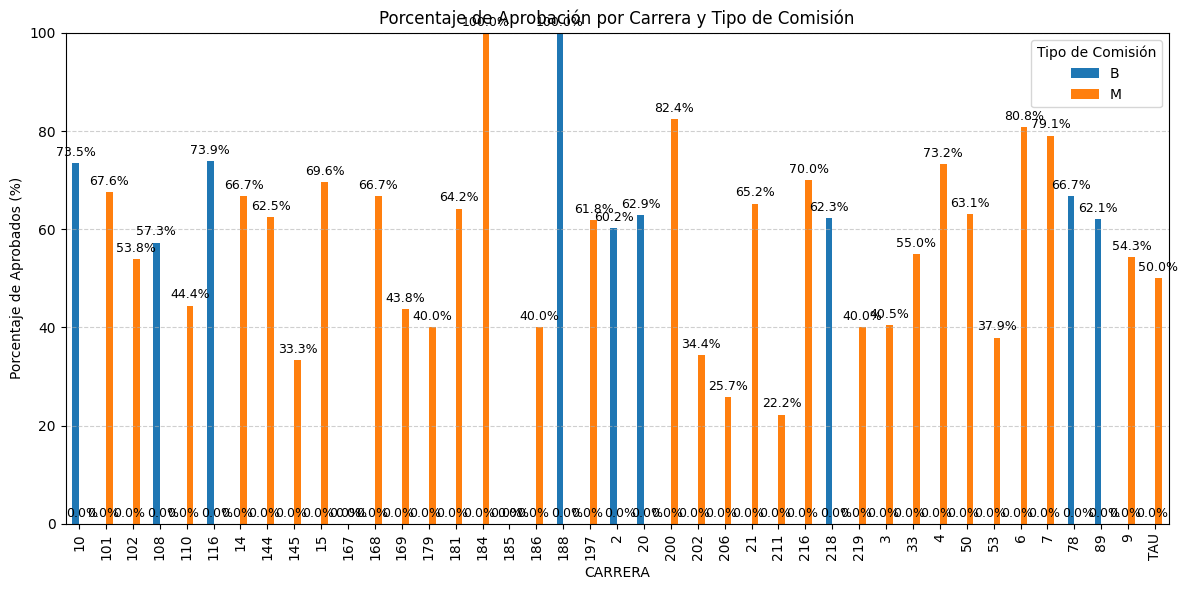

Tasa de aprobación por carrera y tipo de comisión:
TIPO_COMISION      B      M
CARRERA                    
10              73.5    0.0
101              0.0   67.6
102              0.0   53.8
108             57.3    0.0
110              0.0   44.4
116             73.9    0.0
14               0.0   66.7
144              0.0   62.5
145              0.0   33.3
15               0.0   69.6
167              0.0    0.0
168              0.0   66.7
169              0.0   43.8
179              0.0   40.0
181              0.0   64.2
184              0.0  100.0
185              0.0    0.0
186              0.0   40.0
188            100.0    0.0
197              0.0   61.8
2               60.2    0.0
20              62.9    0.0
200              0.0   82.4
202              0.0   34.4
206              0.0   25.7
21               0.0   65.2
211              0.0   22.2
216              0.0   70.0
218             62.3    0.0
219              0.0   40.0
3                0.0   40.5
33               0.0   55

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar solo Aprobado/Desaprobado
df_analisis = df_presentes[df_presentes['NOTA'].isin(['Aprobado', 'Desaprobado'])]

# Convertir CARRERA a string para evitar problemas de tipos mixtos
df_analisis['CARRERA'] = df_analisis['CARRERA'].astype(str)

# Calcular proporciones de aprobación por carrera y tipo de comisión
tabla_carrera = (
    df_analisis
    .groupby(['CARRERA', 'TIPO_COMISION'])['NOTA']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
)

# Agregar columna con el porcentaje de aprobados
tabla_carrera['porcentaje_aprobado'] = tabla_carrera['Aprobado'] * 100

# Pivotar para tener una columna por TIPO_COMISION (B y M)
grafico_df_carrera = tabla_carrera.pivot(index='CARRERA', columns='TIPO_COMISION', values='porcentaje_aprobado').fillna(0)

# Graficar (sin sort_index para evitar problemas, pero podés ordenar manualmente si querés)
ax = grafico_df_carrera.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel('Porcentaje de Aprobados (%)')
ax.set_title('Porcentaje de Aprobación por Carrera y Tipo de Comisión')
ax.set_ylim(0, 100)
ax.legend(title='Tipo de Comisión')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('porcentaje_aprob_carrera.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar la tabla para el informe
print("Tasa de aprobación por carrera y tipo de comisión:")
print(grafico_df_carrera.round(1))